# Logistic Regression on  Amazon Fine food Review 
The Amazon fine food dataset consists of reviews of fine foods from amazon
All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012
Data includes:

* Number of reviews :  568,454 reviews
* Number of user : 256,059 users
* Total Number of Producst : 74,258 products
* Time Span of taking Reviews : from Oct 1999 - Oct 2012
* Number of Columns/fields : 10

***Attributes Information :***
1. Id : Row Id
1. ProductId :Unique identifier for the product (74258 unique values)
1. UserId :Unqiue identifier for the user (256059 unique values)
1. ProfileName : Profile name of the user (218418 unique values )
1. HelpfulnessNumerator : Number of users who found the review helpful 
1. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not 
1. Score : Rating between 1 and 5
1. Time : Timestamp for the review
1. Summary : Brief summary of the review (295744 unique values)
1. Text : Text of the review (393579 unique values)

> **Objective :** *Given a review ,determine whether a review is postive or negative*

**Q].** *How to determine if a review is postive or negative?*

**Ans.** We can use the Score/rating. A rating of 4 or 5 could be considered as positive review & A rating of 1 or 2 can be consider as negative review . A rating of 3 can be consider as neutral and can be ignored . This is the approximation and proxy way to approach way of determing the polarity(positivity/negativity) of reviews.

# Importing important library

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import string
import nltk
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import os
import pickle
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
import swifter
from prettytable import PrettyTable

!pip3 install kaggle


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os
import requests
from IPython.display import display
import zipfile

import os
import requests
from IPython.display import display
import zipfile

def download_dataset(url, file_name, folder='data'):
    """
    Download a public dataset from Kaggle using a direct URL in a Jupyter notebook.

    :param url: Direct download URL of the dataset
    :param file_name: Custom name for the downloaded zip file
    :param folder: Relative folder where the dataset will be saved (default: 'data')
    """
    # Ensure the directory exists
    path = folder
    if not os.path.exists(path):
        os.makedirs(path)

    # Full path for the zip file
    file_path = os.path.join(path, file_name)

    # Download the file from the given URL
    print(f"Downloading dataset as {file_name}...")
    
    response = requests.get(url, stream=True)
    
    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    
    print(f"Download complete. File saved as {file_path}")
    
    return file_path

def extract_zip(file_path, extract_to='.'):
    """
    Extract a zip file in the specified relative directory.

    :param file_path: Path of the zip file to be extracted
    :param extract_to: Path where the files will be extracted (default: current directory)
    """
    print(f"Extracting {file_path} to {extract_to}...")
    
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f"Files extracted to {extract_to}.")

relative_path = "./dataset"
file_name = "amazon_fine_food_reviews.csv"

download_dataset("https://storage.googleapis.com/kaggle-data-sets/18/2157/bundle/archive.zip", file_name=file_name,  folder=relative_path )

#download_dataset("https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/download?datasetVersionNumber=2", file_name=file_name,  folder=relative_path )
#extract_zip(relative_path,  relative_path)

Download complete. File saved as ./dataset/amazon_fine_food_reviews.csv


'./dataset/amazon_fine_food_reviews.csv'

# Reading Data from Sqlite database and changing the review score to be positive and negative.

In [3]:
#Using the sqlite table to read data
con = sqlite3.connect('/Users/krithishetty/Downloads/finefoodreviews/database.sqlite')
# Filtering only Positive and Negative Reviews i.e not taking into consideration those reviews with score=3
filtered_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""",con)
#Given reviews with score>3 a postive rating "1" and reviews with score <3 a negative "0"
#constucting a function
def partition(x):
    if x<3:
        return 0
    return 1
#Changing reviews with score<3 to be negative "0" and score > 3 to be positive "1"
actualscore=filtered_data['Score']
Positve_Negative=actualscore.map(partition)
filtered_data['Score']=Positve_Negative
print("No. of data points in Dataset:",filtered_data.shape)
filtered_data.head(3)


No. of data points in Dataset: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 AND UserId ='AR5J8UI46CURR' ORDER BY ProductId """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**As it can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)**

**ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on**

**It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.**

**The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product**

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Deduplication entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
print('The total data remain after cleaning data ',(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

The total data remain after cleaning data  69.25890143662969


In [8]:
final_data[final_data['HelpfulnessNumerator']>final_data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductID""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:** It was seen that in 2 rows given above the value of HelpfullnessNumerator is Greater than HelpfullnessDenominator which is not practically hence such rows are too removed from dataset

In [10]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.shape

(364171, 10)

(364171, 10)


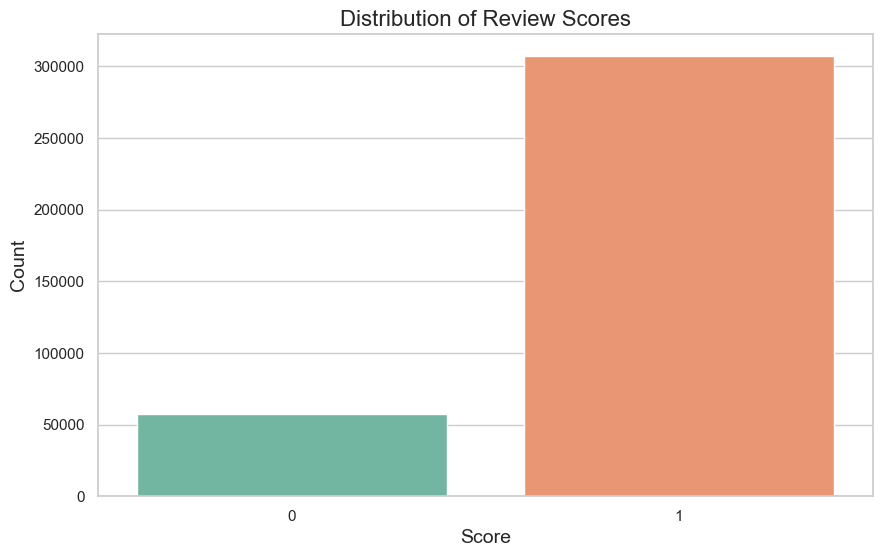

Text(0, 0.5, 'Score')

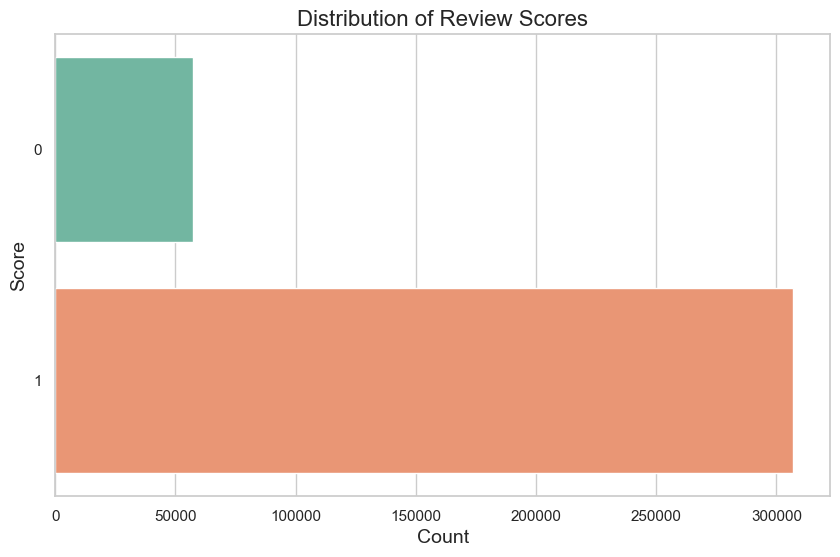

In [11]:
# before starting the next phase of text preprocessing lets see the no. of entries left
print(final_data.shape)
#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()
sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")

# Create a count plot for the 'Score' column with the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(x='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Create a count plot with 'Score' on the y-axis using the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(y='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Text Preprocessing
**Now we have finished deduplication. Now our data requires some preprocessing before we go on futher anlysis and make the prediction model Hence in the preprocessing phase we do the following steps given below**

1. Begin by removing html tags
1. Removing any punctution or limited set of special character:like ,or . or # etc
1. Check the words is made up of english letters and is not alpha-numeric
1. Check to see if the length of the words is greater than 2 (as it was research that there is no adjective in 2 letter)
1. Convert the words to lowercase
1. Remove stopwords
1. Snowball stemming the word(it is observed that Snoball stemming is better that Porter stemming)

***After this we will collect the words and will use to describe positive and negative reviews.***

In [12]:
# Finding the first review with HTML tags
for i, review in enumerate(final_data['Text'].values):
    # Use regex to find HTML tags in the review text
    if re.search(r'<.*?>', review):
        print("First review containing HTML tags:")
        print(review)
        print(f"Found at index: {i}")
        break
else:
    print("No HTML tags found in any review.")


First review containing HTML tags:
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Found at index: 6


In [13]:


# Initialize stopwords and customize the list
stop_words = set(stopwords.words('english'))  # Create a set of stopwords from NLTK
print("Original stopwords:", stop_words)  # Display all stopwords in NLTK

# List of stopwords to exclude
excluding_stop = [
    'against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
    'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 
    'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
    'won', "won't", 'wouldn', "wouldn't"
]

# Remove excluded stopwords from the stop_words set
stop_words = [word for word in stop_words if word not in excluding_stop]

print("****" * 15)
print("Customized stopwords:", stop_words)

# Initialize the Snowball Stemmer
snowball_stemmer = SnowballStemmer('english')
print("\n", "****" * 15)
print("Stemmed word for 'tasty':", snowball_stemmer.stem('tasty'))  # Stemming example

# Function to clean HTML tags from a sentence
def clean_html(text):
    """
    Remove HTML tags from the given text.
    
    :param text: The input string that may contain HTML tags.
    :return: A string with HTML tags removed.
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext

# Function to clean punctuation or special characters from a sentence
def clean_punctuation(text):
    """
    Remove punctuation and special characters from the given text.
    
    :param text: The input string that may contain punctuation or special characters.
    :return: A cleaned string without specified characters.
    """
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', text)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
    return cleaned


Original stopwords: {'hasn', 'being', 'he', 'now', 'had', 'didn', 'theirs', "wouldn't", 'above', "didn't", "weren't", 'me', 'hers', 'of', 't', 'you', 'they', 'most', 're', 'which', "shan't", "wasn't", 'whom', 'we', 'then', 'your', "you've", 'is', 'at', "doesn't", 'yourself', 'against', 'such', 'why', 'o', "hadn't", 'as', 'won', 'wouldn', 'those', 'ours', 'aren', 'my', 'by', 'what', "don't", 'them', 'him', 'am', 'our', 'this', 'mightn', 'was', 'hadn', 'are', 'and', 'herself', 'it', 'more', 'will', 'where', 'her', 'some', 'a', 'ain', "couldn't", "she's", "won't", "isn't", 'about', 'mustn', 'should', 'if', 'll', 'haven', 's', "that'll", 'out', 'than', "needn't", 'can', 'their', 'y', 'through', 'couldn', 'because', 'during', 'having', 've', 'who', 'while', 'shouldn', 'itself', 'below', 'too', 'no', 'under', 'there', 'were', 'the', 'that', 'd', 'himself', 'how', 'has', "aren't", 'other', 'both', 'here', 'does', "hasn't", 'its', 'she', 'but', 'isn', 'themselves', 'shan', 'have', 'once', 'an'

In [14]:
# printing some random reviews
sent_0 = final_data['Text'].values[6]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than s

In [15]:
sent_0=re.sub(r'https\S+','',sent_0)
sent_1000=re.sub(r'https\S+','',sent_1000)
sent_1500=re.sub(r'https\S+','',sent_1500)
sent_4900=re.sub(r'http\S+', '', sent_4900)

print(sent_0)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
pip install beautifulsoup4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install lxml

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [18]:
def decontracted(phrase):
    phrase=re.sub(r"won't",'will not',phrase)
    phrase=re.sub(r"can\'t",'can not',phrase)
    phrase=re.sub(r"n\'t",'not',phrase)
    phrase=re.sub(r"\'re",'are',phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_0=re.sub("\S\d\S","",sent_0).strip()
print(sent_0)
print("="*50)

sent_1500=re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today s Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Unt

In [20]:

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Define the stopwords list
stop = set(stopwords.words('english'))

# Assuming the decontracted function is already defined

def preprocess_sentence(sentence):
    """
    Preprocesses a given sentence by performing the following steps:
    1. Remove URLs.
    2. Remove HTML tags.
    3. Expand contractions.
    4. Remove words containing digits.
    5. Remove special characters.
    6. Convert to lowercase and remove stopwords.
    """

    # Remove URLs
    sentence = re.sub(r"http\S+", "", sentence)
    
    # Remove HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    
    # Expand contractions
    sentence = decontracted(sentence)
    
    # Remove words containing digits
    sentence = re.sub(r"\S*\d\S*", "", sentence).strip()
    
    # Remove special characters, keeping only letters
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
    
    # Convert to lowercase, remove stopwords, and return the cleaned sentence
    sentence = ' '.join(word.lower() for word in sentence.split() if word.lower() not in stop)
    
    return sentence.strip()

# Apply the preprocessing function to the 'Text' column using swifter for faster processing
final_data['Cleaned_Text'] = final_data['Text'].swifter.apply(preprocess_sentence)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
Pandas Apply: 100%|███████████████████████████████████████████████████████████████████████████| 364171/364171 [04:04<00:00, 1489.89it/s]


In [21]:

# Apply the preprocessing function to the 'Summary' column using swifter for faster processing
final_data['Cleaned_Summary'] = final_data['Summary'].swifter.apply(preprocess_sentence)


Pandas Apply: 100%|███████████████████████████████████████████████████████████████████████████| 364171/364171 [02:53<00:00, 2102.16it/s]


In [22]:
pip install bs4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:


# Iterate over sentences and check for HTML tags using BeautifulSoup
for i, sentence in enumerate(final_data['Text'].values):
    # Parse the sentence with BeautifulSoup
    soup = BeautifulSoup(sentence, "html.parser")
    
    # Check if BeautifulSoup parsed any tags
    if soup.find():
        print(f"\n{'='*50}")
        print(f"First sentence containing HTML tags found at index {i}:")
        print(f"{i}) >> {sentence}")
        print(f"{'='*50}\n")
        break
    else:
        print(f"{i}) >> {sentence}")
        print(f"{'-'*50}")

# Final message if no HTML tags are found
if not soup.find():
    print("No sentences containing HTML tags were found in the dataset.")


0) >> this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
--------------------------------------------------
1) >> I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------
2) >> This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
--------------------------------------------------
3) >> Thi

In [24]:
# converting time in unit=sec
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,2007-11-11,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,2007-10-04,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,2004-02-06,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


# Sorting dataset based on 'Time' feature

In [25]:
final_data=final_data.sort_values('Time',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


In [26]:
#Store the final table into an SQLITE table for future
connection=sqlite3.connect('final12.sqlite')
c=connection.cursor
connection.text_factory=str
final_data.to_sql('Reviews',connection,schema=None,if_exists='replace',index=True,index_label=True,chunksize=None,dtype=None)
connection.close()

Equalizing Class Distribution is Important:
Avoiding Model Bias:

If the model is trained on an imbalanced dataset, it might learn to always predict the majority class because doing so minimizes the overall error. This leads to a model that performs well on the majority class but poorly on the minority class.
By sampling an equal number of positive and negative examples, the model is forced to learn patterns in both classes, leading to a more balanced and fair model.
Improved Evaluation Metrics:

Evaluation metrics like accuracy can be misleading in the presence of class imbalance. For example, if 90% of the data is positive, a model that always predicts "positive" will have 90% accuracy, but it would be completely useless for identifying negative samples.
Equalizing the number of samples helps in getting more meaningful evaluation metrics, such as precision, recall, and F1-score, which provide a better understanding of the model's performance across both classes.
Better Generalization:

A model trained on a balanced dataset is more likely to generalize well to new, unseen data. If the test or real-world data has a different distribution (e.g., more negatives), a model trained on balanced data is better equipped to handle this.
Preventing Overfitting:

In some cases, an imbalanced dataset can cause the model to overfit to the majority class because it sees much more data from that class during training. By balancing the classes, the model has to learn from a more diverse set of examples, reducing the risk of overfitting.


In [27]:
# taking equal no. of negative and positive data points
data_pos=final_data[final_data['Score']==1].sample(n=57000)
data_neg=final_data[final_data['Score']==0].sample(n=57000)
final=pd.concat([data_pos,data_neg])
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
466755,504713,B007I7YZJK,A19PP48H5WFFKR,lucienne,2,3,0,2012-07-19,I've been duped!,"So, I thought I was getting a great deal on th...",thought getting great deal product fault guess...,duped
115152,124887,B005BHIESC,A2UO944UHQVLRW,julesybabe,1,1,0,2011-12-07,Worst packaging and drink ever!,I was hesitant of buying this product since th...,hesitant buying product since many mixed revie...,worst packaging drink ever
192518,208745,B003C5TCYU,AM1FWZ76OVLER,S. Srivastava,1,4,0,2011-06-15,he had the poops,ive been reading about a salmonella recall wit...,ive reading salmonella recall product dog comp...,poops
516990,558956,B000REI2X6,ANHRL743VS4JC,Shado716,0,0,0,2007-07-08,Not what I expected,I was expecting a variety of jelly bellies and...,expecting variety jelly bellies bought bags th...,expected
112999,122579,B000CQBZO2,A2ZAGOKRFY9094,"4 Nephews ""numoneaunt""",1,2,0,2009-01-08,Not worth the price,"Go to a major food chain (like shop rite, path...",go major food chain like shop rite pathmark pu...,worth price


Performs hyperparameter tuning for a logistic regression model using cross-validation to determine the optimal regularization strength (C value) for the model.
Evaluate different regularization strengths (C values) for a logistic regression model using cross-validation to find the value that minimizes misclassification error, and then visualizes the relationship between C values and misclassification error.

Evaluating Bag of Words:


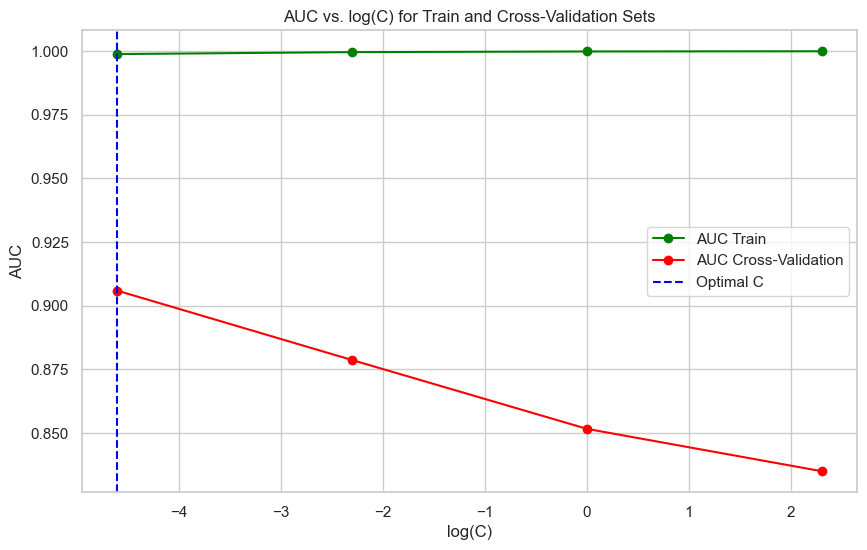

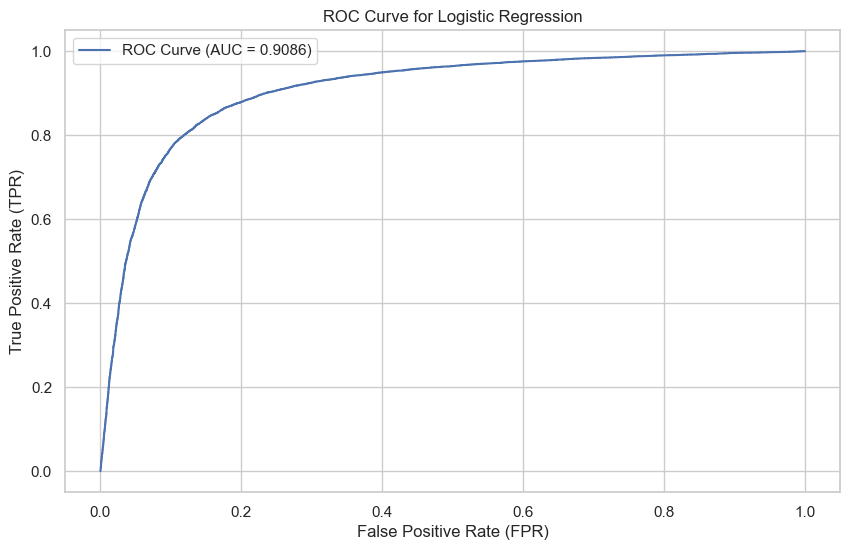

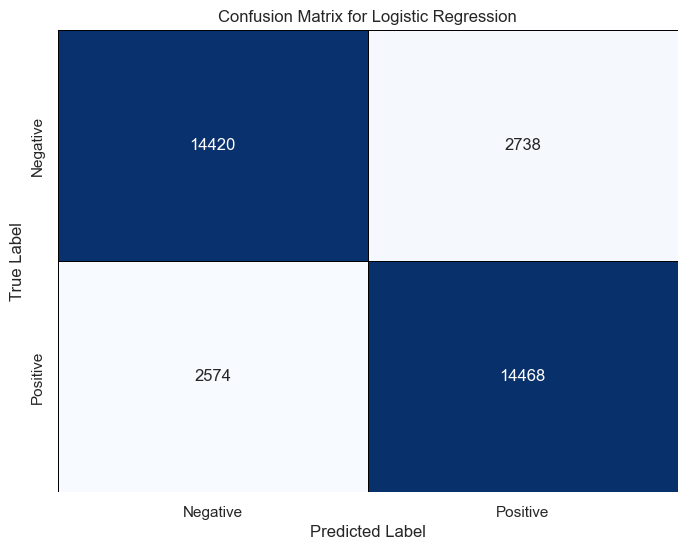

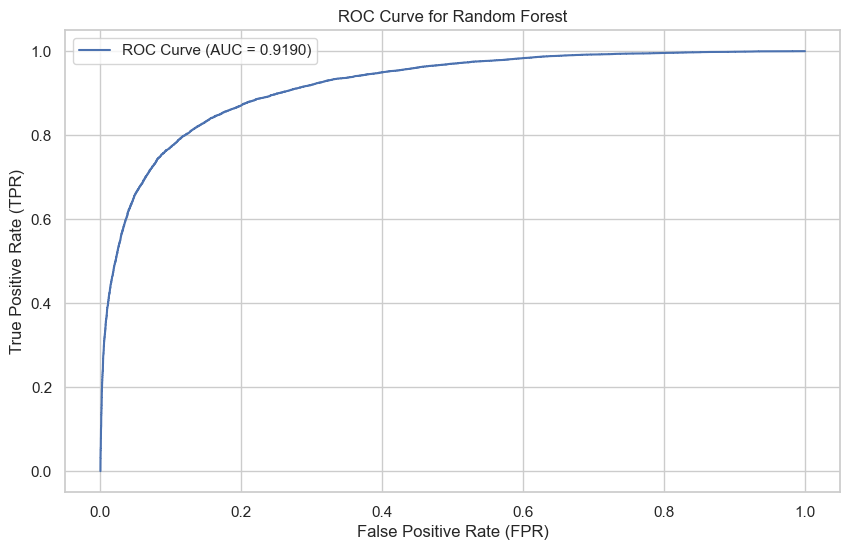

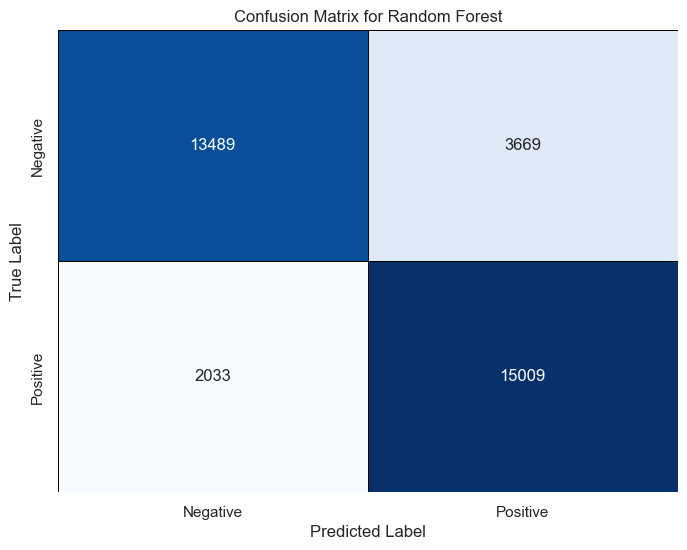

Evaluating TF-IDF:


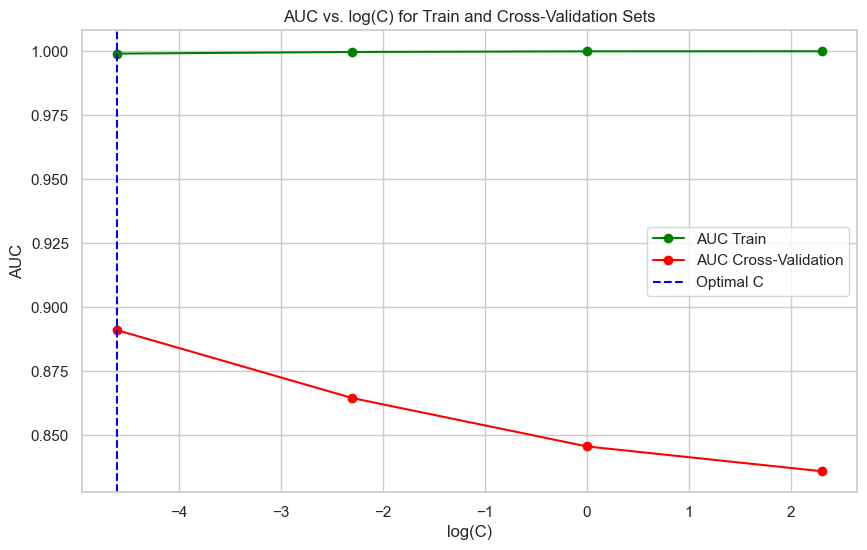

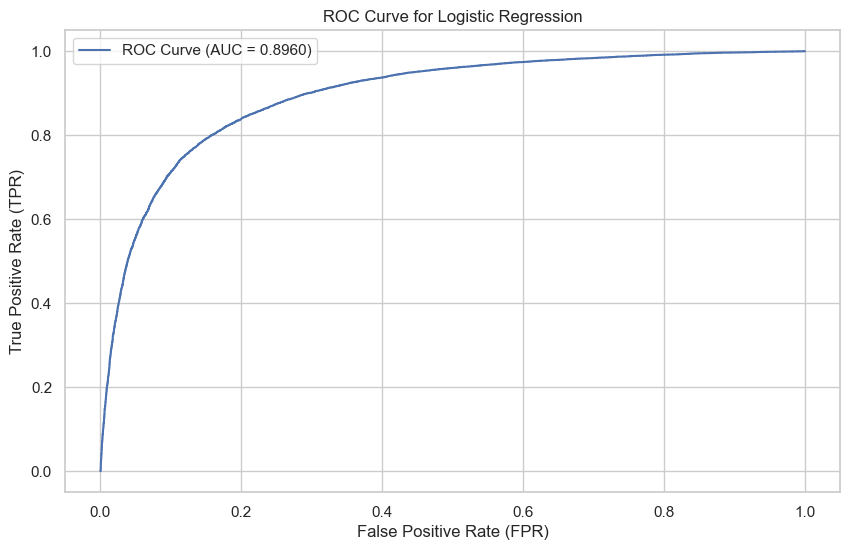

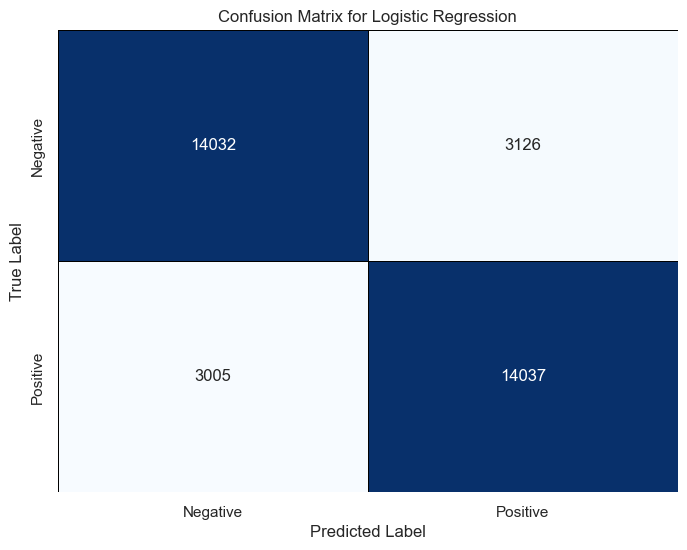

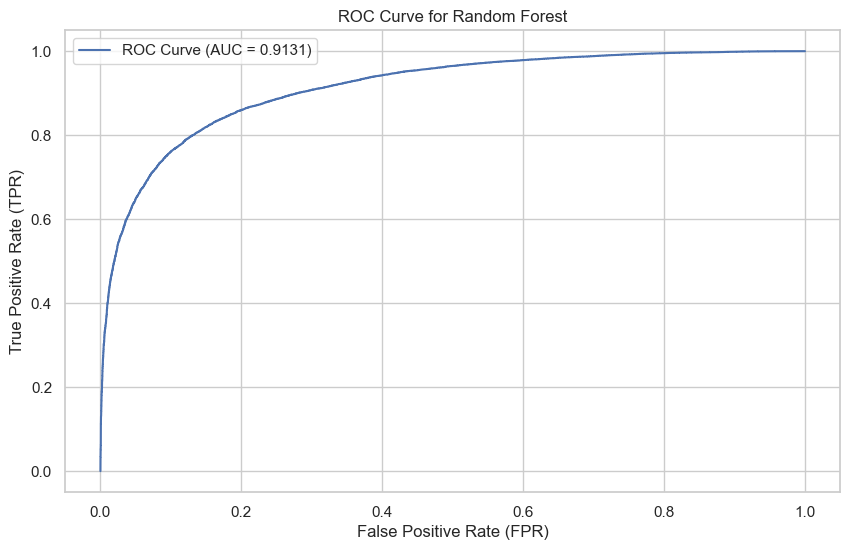

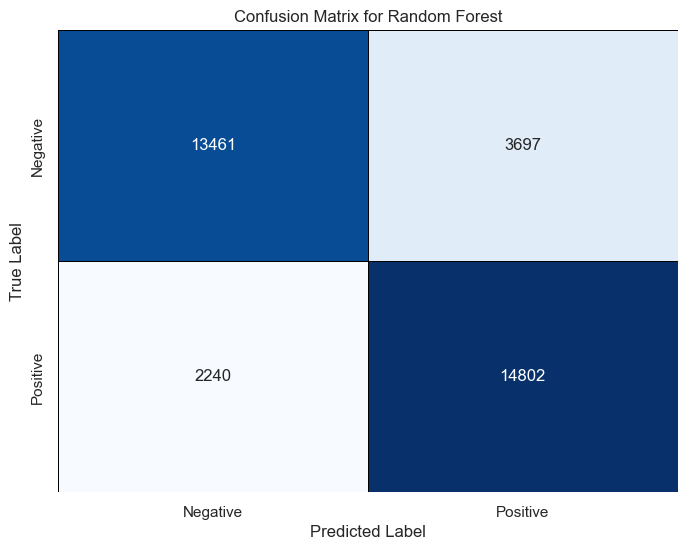

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34200/34200 [02:20<00:00, 243.39it/s]


Evaluating Word2Vec:


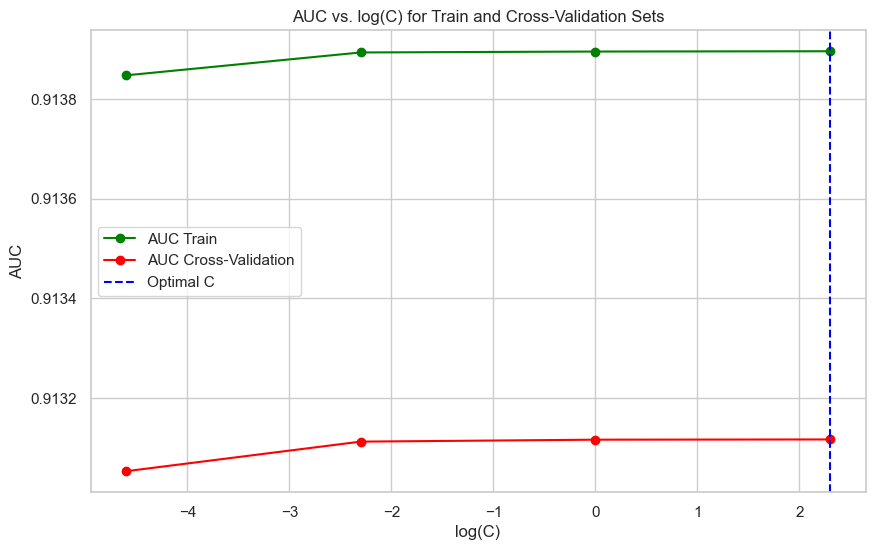

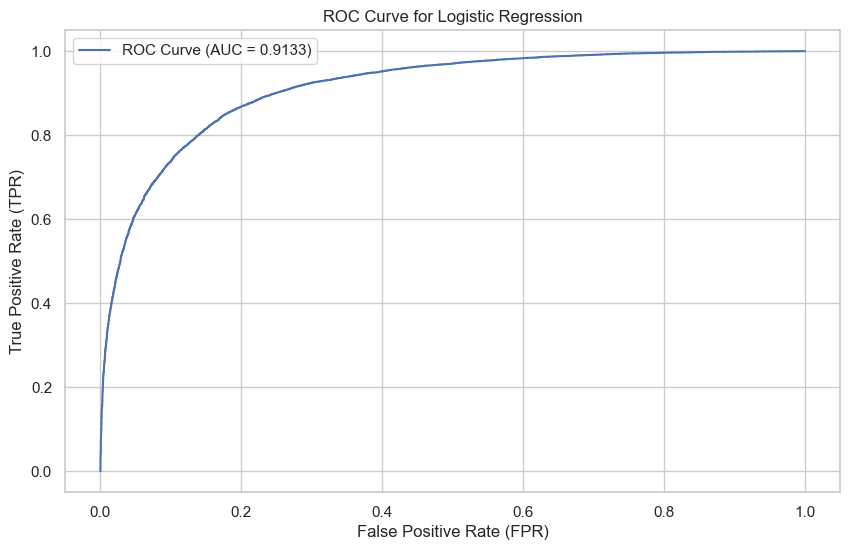

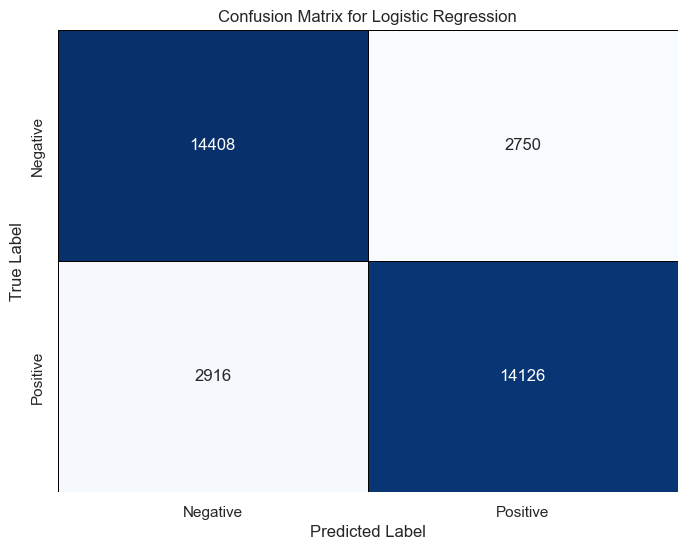

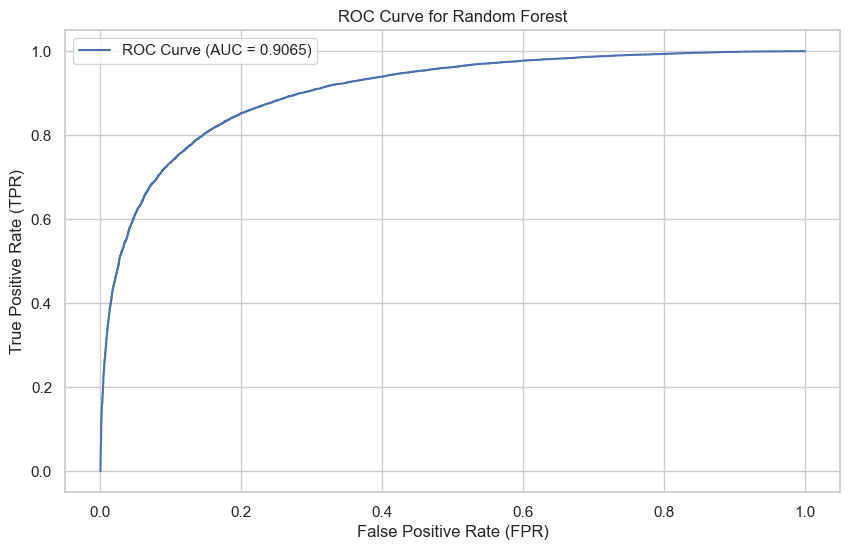

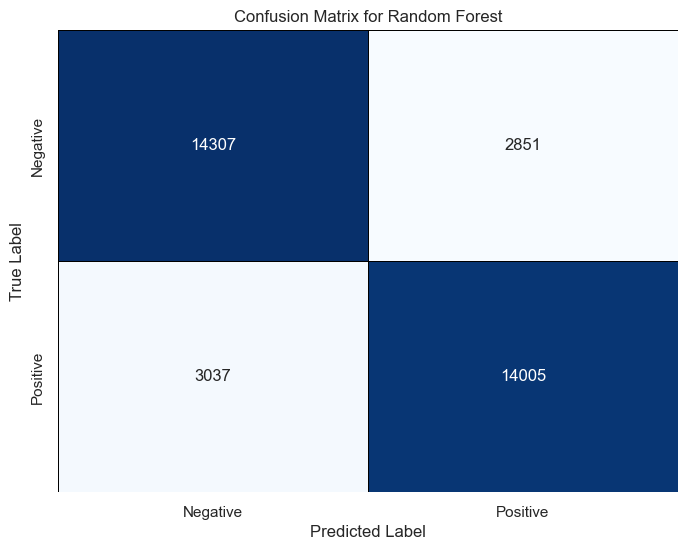

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

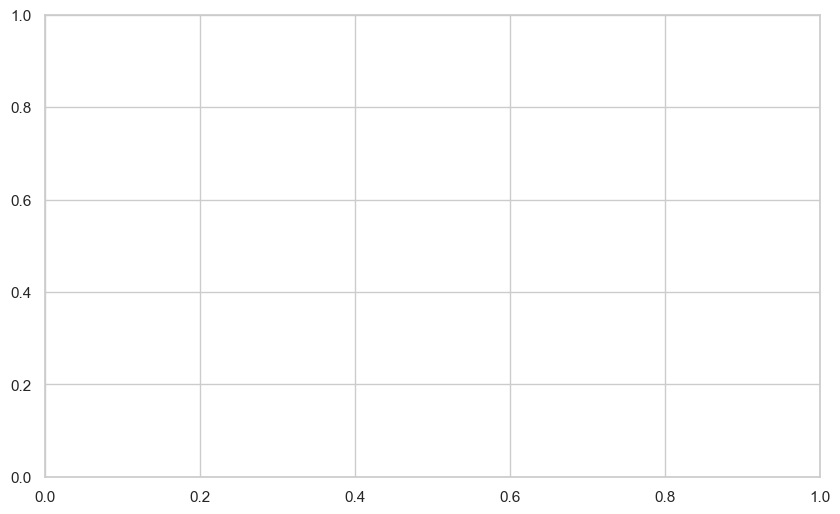

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from prettytable import PrettyTable
from tqdm import tqdm

# Optimized regularization strengths and max iterations
regularization_strengths = [0.01, 0.1, 1, 10]
max_iter = 1000  # Reduced max iterations

# Function to plot the ROC curve
def plot_roc_curve(fpr, tpr, auc, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Function to plot the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_labels = ["Negative", "Positive"]
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=class_labels, index=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to plot AUC vs. Log(C) for Train and Cross-Validation Sets
def plot_auc_vs_logc(auc_train, auc_cv, regularization_strengths):
    log_reg_strengths = [np.log(x) for x in regularization_strengths]
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_strengths, auc_train, color='green', marker='o', label='AUC Train')
    plt.plot(log_reg_strengths, auc_cv, color='red', marker='o', label='AUC Cross-Validation')
    plt.axvline(x=log_reg_strengths[np.argmax(auc_cv)], color='blue', linestyle='--', label='Optimal C')
    plt.legend(loc='best')
    plt.xlabel('log(C)')
    plt.ylabel('AUC')
    plt.title('AUC vs. log(C) for Train and Cross-Validation Sets')
    plt.grid(True)
    plt.show()

# Function to train and evaluate Logistic Regression model with cross-validation
def train_evaluate_logreg(X_train, y_train, X_cv, y_cv, X_test, y_test, regularization_strengths, max_iter=1000):
    auc_train_scores = []
    auc_cv_scores = []

    for C in regularization_strengths:
        model = LogisticRegression(penalty='l2', C=C, max_iter=max_iter)
        model.fit(X_train, y_train)

        auc_train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
        auc_cv_scores.append(roc_auc_score(y_cv, model.predict_proba(X_cv)[:, 1]))

    # Plot AUC vs. log(C) for Train and Cross-Validation Sets
    plot_auc_vs_logc(auc_train_scores, auc_cv_scores, regularization_strengths)

    optimal_C = regularization_strengths[np.argmax(auc_cv_scores)]
    # Train final model with optimal C
    model = LogisticRegression(penalty='l2', C=optimal_C, max_iter=max_iter)
    model.fit(X_train, y_train)

    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)

    # ROC and AUC for test data
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, auc_test, "Logistic Regression")

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_test_pred, "Logistic Regression")

    return auc_test, model

# Function to train and evaluate RandomForest model with cross-validation
def train_evaluate_rf(X_train, y_train, X_cv, y_cv, X_test, y_test, param_grid):
    rf = RandomForestClassifier(random_state=0)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    
    y_test_pred_prob = best_rf.predict_proba(X_test)[:, 1]
    y_test_pred = best_rf.predict(X_test)

    # ROC and AUC for test data
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
    auc_test = roc_auc_score(y_test, y_test_pred_prob)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, auc_test, "Random Forest")

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_test_pred, "Random Forest")

    return auc_test, best_rf

# Shared StandardScaler
scaler = StandardScaler(with_mean=False)

# Vectorizer and training function
def vectorize_and_train(X_train, X_cv, X_test, vectorizer, y_train, y_cv, y_test, regularization_strengths, param_grid_rf):
    vectorizer.fit(X_train)
    X_train_vect = vectorizer.transform(X_train)
    X_cv_vect = vectorizer.transform(X_cv)
    X_test_vect = vectorizer.transform(X_test)

    # Standardize the data once for all models
    X_train_vect = scaler.fit_transform(X_train_vect)
    X_cv_vect = scaler.transform(X_cv_vect)
    X_test_vect = scaler.transform(X_test_vect)

    # Train and evaluate Logistic Regression
    auc_logreg, model_logreg = train_evaluate_logreg(X_train_vect, y_train, X_cv_vect, y_cv, X_test_vect, y_test, regularization_strengths, max_iter)

    # Train and evaluate RandomForest
    auc_rf, model_rf = train_evaluate_rf(X_train_vect, y_train, X_cv_vect, y_cv, X_test_vect, y_test, param_grid_rf)

    return auc_logreg, auc_rf

# Updated Parameters for RandomForest to reduce training time
param_grid_rf = {
    'n_estimators': [100, 150],    # Reduced number of trees to 100 and 150 for faster training
    'max_depth': [10, 20],         # Limited depth to 10 or 20 to prevent overfitting and reduce time
    'min_samples_split': [5, 10]   # Larger values reduce tree complexity, speeding up training
}

# Bag of Words
bow_vectorizer = CountVectorizer()
print("Evaluating Bag of Words:")
auc_bow_logreg, auc_bow_rf = vectorize_and_train(X_train, X_cv, X_test, bow_vectorizer, y_train, y_cv, y_test, regularization_strengths, param_grid_rf)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
print("Evaluating TF-IDF:")
auc_tfidf_logreg, auc_tfidf_rf = vectorize_and_train(X_train, X_cv, X_test, tfidf_vectorizer, y_train, y_cv, y_test, regularization_strengths, param_grid_rf)

# Word2Vec
list_of_X_train = [sentence.split() for sentence in X_train]
list_of_X_cv = [sentence.split() for sentence in X_cv]
list_of_X_test = [sentence.split() for sentence in X_test]

w2v_model = Word2Vec(list_of_X_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

def compute_avg_w2v(sentences, model, w2v_words):
    sentence_vectors = []
    for sentence in tqdm(sentences):
        sent_vec = np.mean([model.wv[word] for word in sentence if word in w2v_words], axis=0)
        if np.isnan(sent_vec).any():  # Handle empty sentence case
            sent_vec = np.zeros(50)
        sentence_vectors.append(sent_vec)
    return sentence_vectors

X_train_avg_w2v = compute_avg_w2v(list_of_X_train, w2v_model, w2v_words)
X_cv_avg_w2v = compute_avg_w2v(list_of_X_cv, w2v_model, w2v_words)
X_test_avg_w2v = compute_avg_w2v(list_of_X_test, w2v_model, w2v_words)

# Standardize the Word2Vec data
X_train_avg_w2v = scaler.fit_transform(X_train_avg_w2v)
X_cv_avg_w2v = scaler.transform(X_cv_avg_w2v)
X_test_avg_w2v = scaler.transform(X_test_avg_w2v)

print("Evaluating Word2Vec:")
auc_avg_w2v_logreg, auc_avg_w2v_rf = train_evaluate_logreg(X_train_avg_w2v, y_train, X_cv_avg_w2v, y_cv, X_test_avg_w2v, y_test, regularization_strengths), train_evaluate_rf(X_train_avg_w2v, y_train, X_cv_avg_w2v, y_cv, X_test_avg_w2v, y_test, param_grid_rf)

# Prepare data for grouped bar plot
model_names = ['Logistic Regression', 'Random Forest']
vectorizer_names = ['Bag of Words', 'TF-IDF', 'Average W2V']




[0.9085705052193139, 0.8960476840888111, (0.9133205102773386, LogisticRegression(C=10, max_iter=1000))]
[0.9190404300537147, 0.9131346167533626, (0.9065091327133902, RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=150,
                       random_state=0))]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

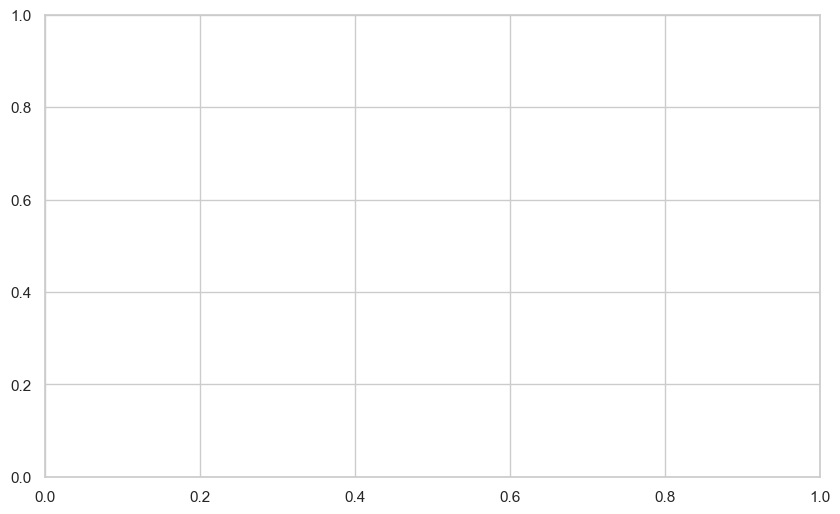

In [51]:
# Ensure all values are scalars (convert sequences to a single number, like mean or first element)
def ensure_scalar(value):
    if isinstance(value, (list, np.ndarray)):  # If it's a list or array, get the mean or first element
        return np.mean(value)  # Or use value[0] if the first element is needed
    return value

# Apply the ensure_scalar function to all AUC variables
auc_bow_logreg = ensure_scalar(auc_bow_logreg)
auc_tfidf_logreg = ensure_scalar(auc_tfidf_logreg)
auc_avg_w2v_logreg = ensure_scalar(auc_avg_w2v_logreg)

auc_bow_rf = ensure_scalar(auc_bow_rf)
auc_tfidf_rf = ensure_scalar(auc_tfidf_rf)
auc_avg_w2v_rf = ensure_scalar(auc_avg_w2v_rf)

# Now define the AUC scores for plotting
auc_scores_logreg = [auc_bow_logreg, auc_tfidf_logreg, auc_avg_w2v_logreg[0]]
print(auc_scores_logreg)
auc_scores_rf = [auc_bow_rf, auc_tfidf_rf, auc_avg_w2v_rf]
vectorizer_names = ['Bag of Words', 'TF-IDF', 'Average W2V']

print(auc_scores_rf)
# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(vectorizer_names))

# Plot bars for Logistic Regression
bar1 = ax.bar(index, auc_scores_logreg, bar_width, label='Logistic Regression')

# Plot bars for Random Forest
bar2 = ax.bar(index + bar_width, auc_scores_rf, bar_width, label='Random Forest')

# Add labels and title
ax.set_xlabel('Vectorizer')
ax.set_ylabel('AUC Score')
ax.set_title('Model Comparison: AUC Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(vectorizer_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Model comparison table
from prettytable import PrettyTable
comparison_table = PrettyTable()
comparison_table.field_names = ["Vectorizer", "AUC Logistic Regression", "AUC RandomForest"]

comparison_table.add_row(["Bag of Words", auc_bow_logreg, auc_bow_rf])
comparison_table.add_row(["TF-IDF", auc_tfidf_logreg, auc_tfidf_rf])
comparison_table.add_row(["Average W2V", auc_avg_w2v_logreg, auc_avg_w2v_rf])

print(comparison_table)


In [40]:
# Function to analyze and classify a review
def analysis_review(review_text, model, vectorizer):
    review_vectorized = vectorizer.transform([review_text])
    sentiment_prob = model.predict_proba(review_vectorized)[0, 1]
    sentiment = 'Positive' if sentiment_prob >= 0.5 else 'Negative'
    return sentiment, sentiment_prob

# Example review analysis
example_review = "This product is fantastic! I love it."
sentiment, probability = analysis_review(example_review, model_tfidf, tfidf_vect)
print(f"Review: '{example_review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")


Review: 'This product is fantastic! I love it.'
Sentiment: Positive (Probability: 0.5140)


In [41]:
example_review = "This product is bad! I dont love it."
sentiment, probability = analysis_review(example_review, model_tfidf, tfidf_vect)
print(f"Review: '{example_review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")


Review: 'This product is bad! I dont love it.'
Sentiment: Negative (Probability: 0.4937)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

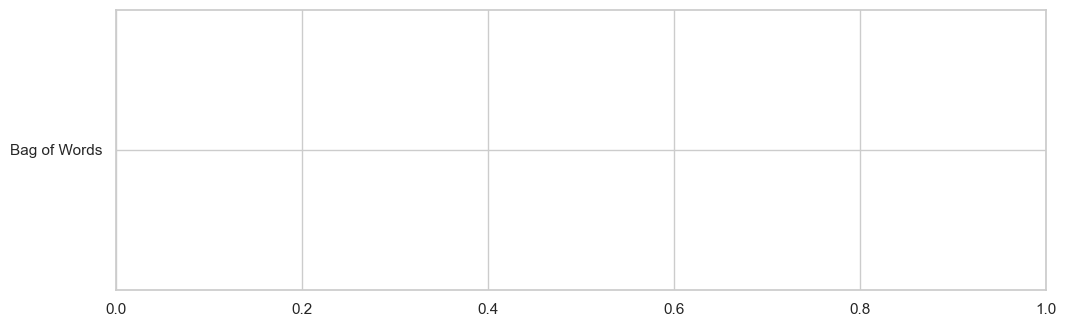

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison_auc(models, auc_logreg_scores, auc_rf_scores):
    """
    Plots the model comparison by AUC scores for Logistic Regression and Random Forest with color gradient and labels.

    Parameters:
    models (list): List of model names (e.g., ['Bag of Words', 'TF-IDF', 'Average W2V']).
    auc_logreg_scores (list): AUC scores for Logistic Regression models.
    auc_rf_scores (list): AUC scores for Random Forest models.

    Returns:
    None
    """
    # Create a colormap based on the AUC scores
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

    # Set up figure
    plt.figure(figsize=(12, 8))

    # Plot for Logistic Regression
    plt.subplot(2, 1, 1)  # Top subplot
    bars_logreg = plt.barh(models, auc_logreg_scores, color=colors)
    plt.title('Model Comparison (Logistic Regression)', fontsize=16, weight='bold')
    plt.xlabel('AUC Score', fontsize=14)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Add labels inside the bars for Logistic Regression
    for index, value in enumerate(auc_logreg_scores):
        plt.text(value - 0.02, index, f'{value:.4f}', va='center', ha='right', fontsize=12, color='red', weight='bold')

    # Adjust x-axis limits to prevent text from overlapping the border
    plt.xlim(0.85, 1.0)

    # Plot for Random Forest
    plt.subplot(2, 1, 2)  # Bottom subplot
    bars_rf = plt.barh(models, auc_rf_scores, color=colors)
    plt.title('Model Comparison (Random Forest)', fontsize=16, weight='bold')
    plt.xlabel('AUC Score', fontsize=14)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Add labels inside the bars for Random Forest
    for index, value in enumerate(auc_rf_scores):
        plt.text(value - 0.02, index, f'{value:.4f}', va='center', ha='right', fontsize=12, color='red', weight='bold')

    # Adjust x-axis limits to prevent text from overlapping the border
    plt.xlim(0.85, 1.0)

    # Add color bar for reference
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(auc_logreg_scores + auc_rf_scores), vmax=max(auc_logreg_scores + auc_rf_scores)))
    sm.set_array([])
    plt.colorbar(sm, orientation='horizontal', pad=0.15, aspect=40)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with AUC values from training:
models = ['Bag of Words', 'TF-IDF', 'Average W2V']
auc_logreg_scores = [auc_bow_logreg, auc_tfidf_logreg, auc_avg_w2v_logreg]  # Logistic Regression AUCs
auc_rf_scores = [auc_bow_rf, auc_tfidf_rf, auc_avg_w2v_rf]  # Random Forest AUCs

plot_model_comparison_auc(models, auc_logreg_scores, auc_rf_scores)


In [33]:
review = "This product was excellent and exceeded my expectations."

example_review = "This product is bad! I dont love it."
sentiment, probability = analysis_review(review, model_tfidf, tfidf_vect)
print(f"Review: '{review}'")
print(f"Sentiment: {sentiment} (Probability: {probability:.4f})")

Review: 'This product was excellent and exceeded my expectations.'
Sentiment: Positive (Probability: 0.5050)
